In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import sparse as sps
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Classifying News Articles

In this project, I will create models that classify news articles based on word counts. The models I will be using are Naive Bayes, K Nearest Neighbor, and KMeans. I will also be applying some techniques like dimensionality reduction and automated hyperparameter decisions. 

In order to use text as data, I will need to use a vectorizer. In this project, I use TFIDFVectorizer. The way a vectorizer works is it first takes in the word counts of a document and turns each word into a vector. TFIDF stands for term frequency inverse document frquency. This means that words that don't appear as often have a higher weight to them. This means that words that are specific to a certain category have a higher weight to them, making it easier to categorize them correctly. All of the vectors in a document are put together into a matrix. Accuracies of models are calculated using cosine similarity. 

Dimensionality reduction is used in this project to reduce time and size costs. 

I will use pipelines in this project quite a bit because I believe it reflects a real life project more. Pipelines provide more reuseability and can be easier to see what is happening under the hood.

## Getting Data Ready

Obtaining data, putting it into a dataframe, making training and testing sets, and describing the categories of articles.

In [2]:
rng = np.random.RandomState(20201024)

In [3]:
#Takes in observations from multiple datasets. Puts them into one dataframe
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text(encoding='latin1'))
     for f in Path('bbc').glob('*/*.txt')),
    columns=['category', 'file', 'text']
)

In [4]:
articles

,category,file,text
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...
...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams\n\nBT is intr...
2221,tech,398.txt,Spam e-mails tempt net shoppers\n\nComputer us...
2222,tech,399.txt,Be careful how you code\n\nA new European dire...
2223,tech,400.txt,US cyber security chief resigns\n\nThe man mak...


In [5]:
#Make training and testing masks
test = articles.sample(frac=0.20, random_state=rng)
train_mask = pd.Series(True, index=articles.index)
train_mask[test.index] = False
train = articles[train_mask].copy()

In [6]:
articles['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

<AxesSubplot:xlabel='category', ylabel='count'>

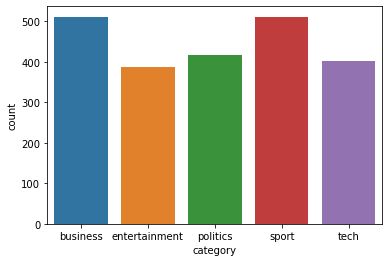

In [7]:
sns.countplot(x=articles['category'])

## Naive Bayes Classifier

A simple model that is often quite effective.

In [8]:
#A list of stop words to get rid of. Deletion of stop words should only have a positive effect on classification
stopWords = ['the','to','and','in','of','but','for','it','was','have','on','that','with','at','is','are','be','or',
            'he','his','we','not','has','they','its','by']


bayesPipe = Pipeline([
    ('parse', CountVectorizer()), #Turns each word into a vector with a wordcount
    ('bayes-classify', MultinomialNB()) #Naive Bayes
])
bayesPipe.fit(train['text'], train['category'])

Pipeline(steps=[('parse', CountVectorizer()),
                ('bayes-classify', MultinomialNB())])

In [9]:
#Training accuracy
(bayesPipe.predict(train['text']) == train['category']).mean()

0.994943820224719

In [10]:
#Testing accuracy
(bayesPipe.predict(test['text']) == test['category']).mean()

0.9730337078651685

A 97% accuracy rate is very good for this kind of question. Let's see if this accuracy can be increased by using other models.

## K Nearest Neighbor

Use TFIDVectorizer to turn words into vectors and then vectors into a matrix. Then use KNN to try and classify into the correct article category. 

In [11]:
#Make a pipeline using Tfid vectorizer to convert data into usable form. Then use KNN on data
knnPipe = Pipeline([
    ('tfid',TfidfVectorizer(stop_words=stopWords)),
    ('knn',KNeighborsClassifier())
])

In [12]:
#Fit to training data
knnPipe.fit(train['text'], train['category'])

Pipeline(steps=[('tfid',
                 TfidfVectorizer(stop_words=['the', 'to', 'and', 'in', 'of',
                                             'but', 'for', 'it', 'was', 'have',
                                             'on', 'that', 'with', 'at', 'is',
                                             'are', 'be', 'or', 'he', 'his',
                                             'we', 'not', 'has', 'they', 'its',
                                             'by'])),
                ('knn', KNeighborsClassifier())])

In [13]:
#Training accuracy
(knnPipe.predict(train['text']) == train['category']).mean()

0.9674157303370786

In [14]:
#Testing accuracy
(knnPipe.predict(test['text']) == test['category']).mean()

0.9235955056179775

That is a pretty good testing accuracy. But Naive Bayes still performed better. Let's see if we can increase accuracy by using GridSearchCV to find the best hyperparameter K.

In [15]:
knnCvPipe = Pipeline([
    ('parse', TfidfVectorizer(stop_words=stopWords)),
    ('cvclass', GridSearchCV(KNeighborsClassifier(), { #Search for the best hyperparameter
        'n_neighbors': [1, 2, 3, 5, 7, 10] # A few number of neighbors to choose from.
    }, scoring=make_scorer(accuracy_score)))
])
knnCvPipe.fit(train['text'], train['category'])

Pipeline(steps=[('parse',
                 TfidfVectorizer(stop_words=['the', 'to', 'and', 'in', 'of',
                                             'but', 'for', 'it', 'was', 'have',
                                             'on', 'that', 'with', 'at', 'is',
                                             'are', 'be', 'or', 'he', 'his',
                                             'we', 'not', 'has', 'they', 'its',
                                             'by'])),
                ('cvclass',
                 GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 5, 7, 10]},
                              scoring=make_scorer(accuracy_score)))])

In [16]:
#Neighborhood size the tuning selected.
knnCvPipe['cvclass'].best_estimator_

KNeighborsClassifier(n_neighbors=10)

GridSearchCV found that the best hyperparameter is K = 10.

In [17]:
#Testing accuracy
accuracy_score(test['category'], knnCvPipe.predict(test['text']))

0.9303370786516854

Well 0.93 is better than 0.92, the accuracy of the previous KNN model, but only by a little bit. 

## Using Dimensionality Reduction 

Utilize TruncatedSVD to reduce the dimensionality of matrices. Then perform KNN.

In [18]:
svdKnnPipe = Pipeline([
    ('parse', TfidfVectorizer(stop_words=stopWords)), 
    ('svd', TruncatedSVD(8, random_state=rng)), #Reduce dimensions of matrices 
    ('knn-classify', KNeighborsClassifier(5)) 
])
svdKnnPipe.fit(train['text'], train['category'])

Pipeline(steps=[('parse',
                 TfidfVectorizer(stop_words=['the', 'to', 'and', 'in', 'of',
                                             'but', 'for', 'it', 'was', 'have',
                                             'on', 'that', 'with', 'at', 'is',
                                             'are', 'be', 'or', 'he', 'his',
                                             'we', 'not', 'has', 'they', 'its',
                                             'by'])),
                ('svd',
                 TruncatedSVD(n_components=8,
                              random_state=RandomState(MT19937) at 0x27C497BC040)),
                ('knn-classify', KNeighborsClassifier())])

In [19]:
#Training accuracy
(svdKnnPipe.predict(train['text']) == train['category']).mean()

0.9696629213483146

In [20]:
#Testing accuracy
(svdKnnPipe.predict(test['text']) == test['category']).mean()

0.946067415730337

This accuracy is even better than the KNN model that picked out its own best hyperparameter. Looks like dimensionality reduction works. Naive Bayes still outperforms this model, however.

## Evaluating Accuracy

Now I will put all of the accuracies into one graph to compare.

In [21]:
#Put all training accuracies into one dataframe
trainFrame = pd.DataFrame({
    'NaiveBay': bayesPipe.predict(train['text']),
    'kNN': knnPipe.predict(train['text']),
    'kNNCV': knnCvPipe.predict(train['text']),
    'kNNSVD': svdKnnPipe.predict(train['text'])
})
trainAcc = trainFrame.apply(lambda s: accuracy_score(train['category'], s))
trainAcc

NaiveBay    0.994944
kNN         0.967416
kNNCV       0.962360
kNNSVD      0.969663
dtype: float64

In [22]:
#Put all testing accuracies into one dataframe
testFrame = pd.DataFrame({
    'NaiveBay': bayesPipe.predict(test['text']),
    'kNN': knnPipe.predict(test['text']),
    'kNNCV': knnCvPipe.predict(test['text']),
    'kNNSVD': svdKnnPipe.predict(test['text'])
})
testAcc = testFrame.apply(lambda s: accuracy_score(test['category'], s))
testAcc

NaiveBay    0.973034
kNN         0.923596
kNNCV       0.930337
kNNSVD      0.946067
dtype: float64

In [23]:
#Put both test and training accuracies into one dataframe.
allModels = pd.concat({
    'Train': trainAcc,
    'Test': testAcc
}, names=['Set', 'Algorithm']).reset_index(name='Accuracy')
allModels

,Set,Algorithm,Accuracy
0,Train,NaiveBay,0.994944
1,Train,kNN,0.967416
2,Train,kNNCV,0.962360
3,Train,kNNSVD,0.969663
4,Test,NaiveBay,0.973034
5,Test,kNN,0.923596
6,Test,kNNCV,0.930337
7,Test,kNNSVD,0.946067


C:\Users\zacki\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


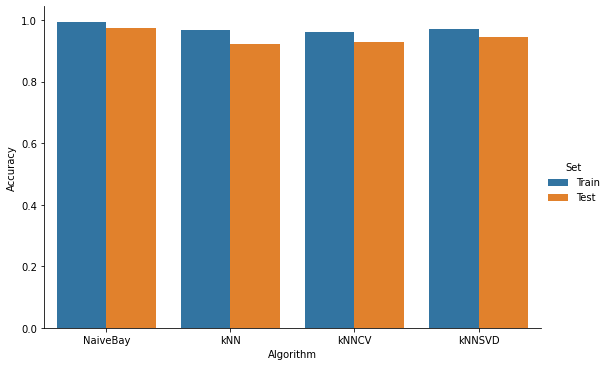

In [35]:
sns.catplot('Algorithm', 'Accuracy', hue='Set', data=allModels, kind='bar', aspect=1.5)

Looks like all of the models performed similarly. The training sets have a higher accuracy than the testing sets, but it is nothing out of the ordinary. Just a little overfitting. Naive Bayes outperformed all of the other models by a somewhat small margin.

## Clustering

Now I will use KMeans to try and classify articles into their respective category. There are 5 real categories.

In [25]:
#Create a pipeline that clusters the articles based on which important words are used the most. Uses KMeans.
clusterPipe = Pipeline([
    ('tfidVector',TfidfVectorizer(stop_words=stopWords)),
    ('cluster',KMeans(5,random_state=rng)) #Use KMeans to cluster the articles into K = 5 clusters.
])

In [26]:
clusterPipe.fit(train['text'])

Pipeline(steps=[('tfidVector',
                 TfidfVectorizer(stop_words=['the', 'to', 'and', 'in', 'of',
                                             'but', 'for', 'it', 'was', 'have',
                                             'on', 'that', 'with', 'at', 'is',
                                             'are', 'be', 'or', 'he', 'his',
                                             'we', 'not', 'has', 'they', 'its',
                                             'by'])),
                ('cluster',
                 KMeans(n_clusters=5,
                        random_state=RandomState(MT19937) at 0x27C497BC040))])

C:\Users\zacki\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


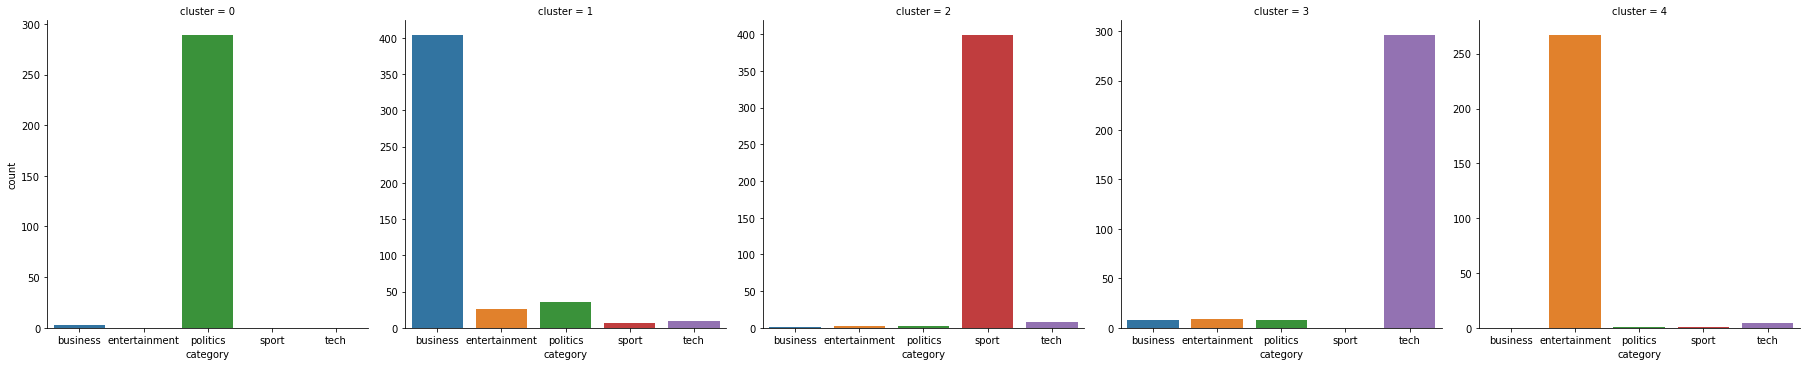

In [27]:
trainCluster = pd.DataFrame({
    'category': train['category'],
    'cluster': clusterPipe.named_steps['cluster'].labels_
})
sns.catplot('category', col='cluster', data=trainCluster, kind='count', sharey=False)

When using 5 clusters, it appears that KMeans does a good job of picking which article is which category. Only the 1 and 3 clusters have more than a few misclassifications. 

### Using 6 Clusters instead of 5

Since using 5 clusters worked so well, lets see what using KMeans with 6 clusters does. There are only 5 real categories of articles, so I expect 6 clusters to perform worse.

In [28]:
kMeans6 = Pipeline([
    ('tfidVector', TfidfVectorizer(stop_words=stopWords)),
    ('cluster', KMeans(6, random_state=rng)) #Use 6 clusters
])
kMeans6.fit(train['text'])

Pipeline(steps=[('tfidVector',
                 TfidfVectorizer(stop_words=['the', 'to', 'and', 'in', 'of',
                                             'but', 'for', 'it', 'was', 'have',
                                             'on', 'that', 'with', 'at', 'is',
                                             'are', 'be', 'or', 'he', 'his',
                                             'we', 'not', 'has', 'they', 'its',
                                             'by'])),
                ('cluster',
                 KMeans(n_clusters=6,
                        random_state=RandomState(MT19937) at 0x27C497BC040))])

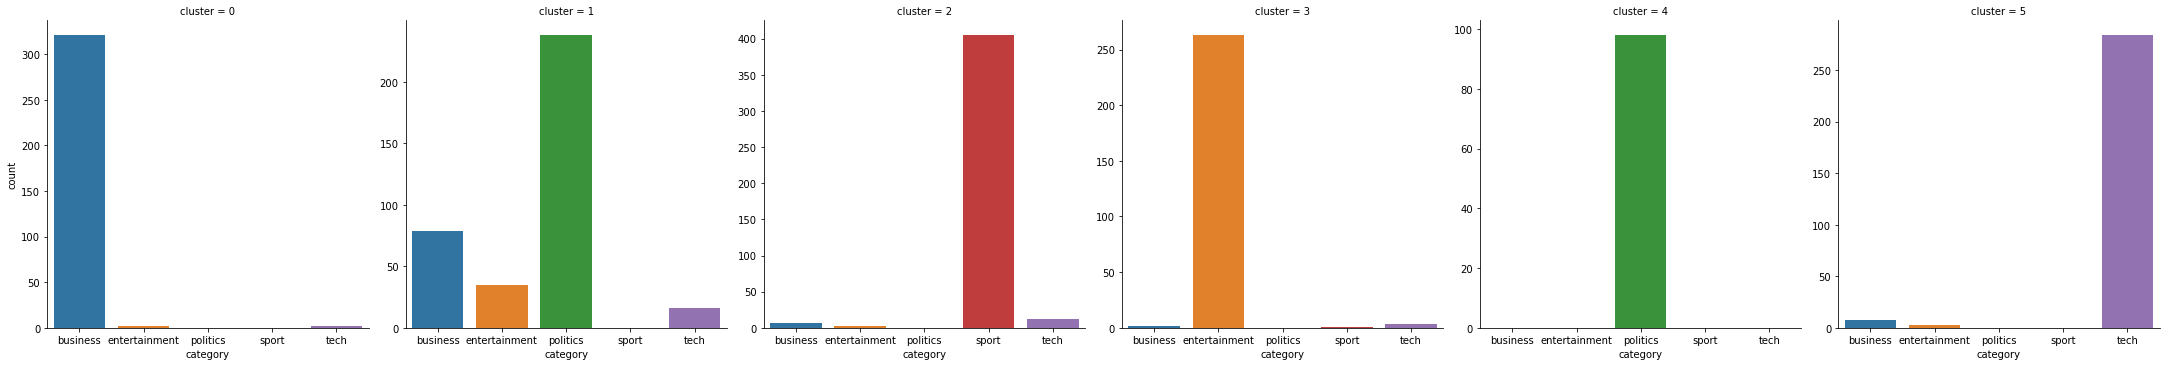

In [29]:
trainCluster1 = pd.DataFrame({
    'category': train['category'],
    'cluster': kMeans6.named_steps['cluster'].labels_
})
sns.catplot(x='category', col='cluster', data=trainCluster1, kind='count', sharey=False)

This model performs worse than the KMeans model with 5 clusters. In the cluster 1 graph there is quite a lot of variance in which categories go to that cluster. The KMeans model with 5 clusters certainly worked better.

## Visualizing the Clusters

I will use t-SNE or t-distributed Stochastic Neighbor Embedding to visualize the KMeans model with 6 clusters. This will hopefully help to understand the data better.

In [30]:
snePipe = Pipeline([
    ('svd', TruncatedSVD(50, random_state=rng)), #50 recommended by TNSE docs
    ('t-sne', TSNE(random_state=rng))
])
sne = TfidfVectorizer(stop_words=stopWords)
trainSne = sne.fit_transform(train['text'])

TSNE does not support transform, but it doesn support fit_transform. There are quite a few more articles than there are clusters, so this should not break much. 

In [31]:
#vstack stacks sparse matrices vertically
tcMat = sps.vstack([trainSne, kMeans6.named_steps['cluster'].cluster_centers_]) 

fitSne = snePipe.fit_transform(tcMat)

In [32]:
train_sne = pd.DataFrame(fitSne[:-6, :], columns=['SNE0', 'SNE1'], index=train.index)
train_sne['category'] = train['category']

C:\Users\zacki\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


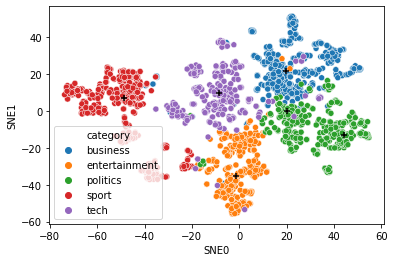

In [33]:
sns.scatterplot('SNE0', 'SNE1', hue='category', data=train_sne)
plt.scatter(fitSne[-6:, 0], fitSne[-6:, 1], color='black', marker='+')
plt.show()

This is a visualization of the news articles. Most of the articles stay in their own general space, but it appears that some are in the space of other categories. This would probably have been caused by one type of article using lots of buzzwords typically used by a different category of article. For instance, an entertainment article about a hacker movie might contain lots of words that are usually only used by tech articles. 